<a href="https://colab.research.google.com/github/dunnohow/LSTM_Autoencoder/blob/master/AE_LSTM_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq arff2pandas

In [2]:
import copy
import time
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm
import torch
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader
import torch.nn.functional as F
from arff2pandas import a2p
import argparse
from copy import deepcopy

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


<br>

#**Load Data**

In [4]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
path = "/content/drive/My Drive/LSTM_prac/sales/"
os.listdir(path)

['sales_train.csv', 'AE_LSTM_sales.ipynb']

In [6]:
device = torch.device("cuda")

In [7]:
train = pd.read_csv(path + 'sales_train.csv')
train['date'] = pd.to_datetime(train['date'])
train.shape

(2935849, 6)

In [8]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [9]:
train['item_sales_total'] = train['item_price'] * train['item_cnt_day']

In [10]:
train = train.drop(columns=['item_id', 'item_price', 'item_cnt_day','date_block_num'])

In [11]:
train = train.pivot_table(index='date',columns='shop_id',aggfunc=sum)

In [12]:
train = train.fillna(0)

In [13]:
scaler = StandardScaler()

In [14]:
train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)

In [15]:
train

item_sales_total                      ...                              
shop_id               0         1         2   ...        57        58        59
0              -0.217333 -0.208191 -0.240069  ... -1.181296 -1.085661 -1.097596
1               4.836933  4.311707 -0.954461  ... -1.181296 -1.085661 -0.273259
2              -0.217333 -0.208191 -0.489790  ...  0.156238  0.097410  0.220214
3              -0.217333 -0.208191 -0.318642  ... -0.543487 -0.575537 -0.278002
4              -0.217333 -0.208191 -0.434025  ... -0.225518 -1.085661  0.075472
...                  ...       ...       ...  ...       ...       ...       ...
1029           -0.217333 -0.208191 -0.448476  ... -0.254844  0.186954 -0.618928
1030           -0.217333 -0.208191  0.568108  ... -0.643961 -0.369044 -0.065682
1031           -0.217333 -0.208191 -0.662037  ... -0.461141 -0.252047 -0.753382
1032           -0.217333 -0.208191  0.156066  ... -0.127520 -0.393215 -0.349118
1033           -0.217333 -0.208191 -0.662888  ... -0.927783 -0.049359 -0.723721

[1034 rows x 60 columns]

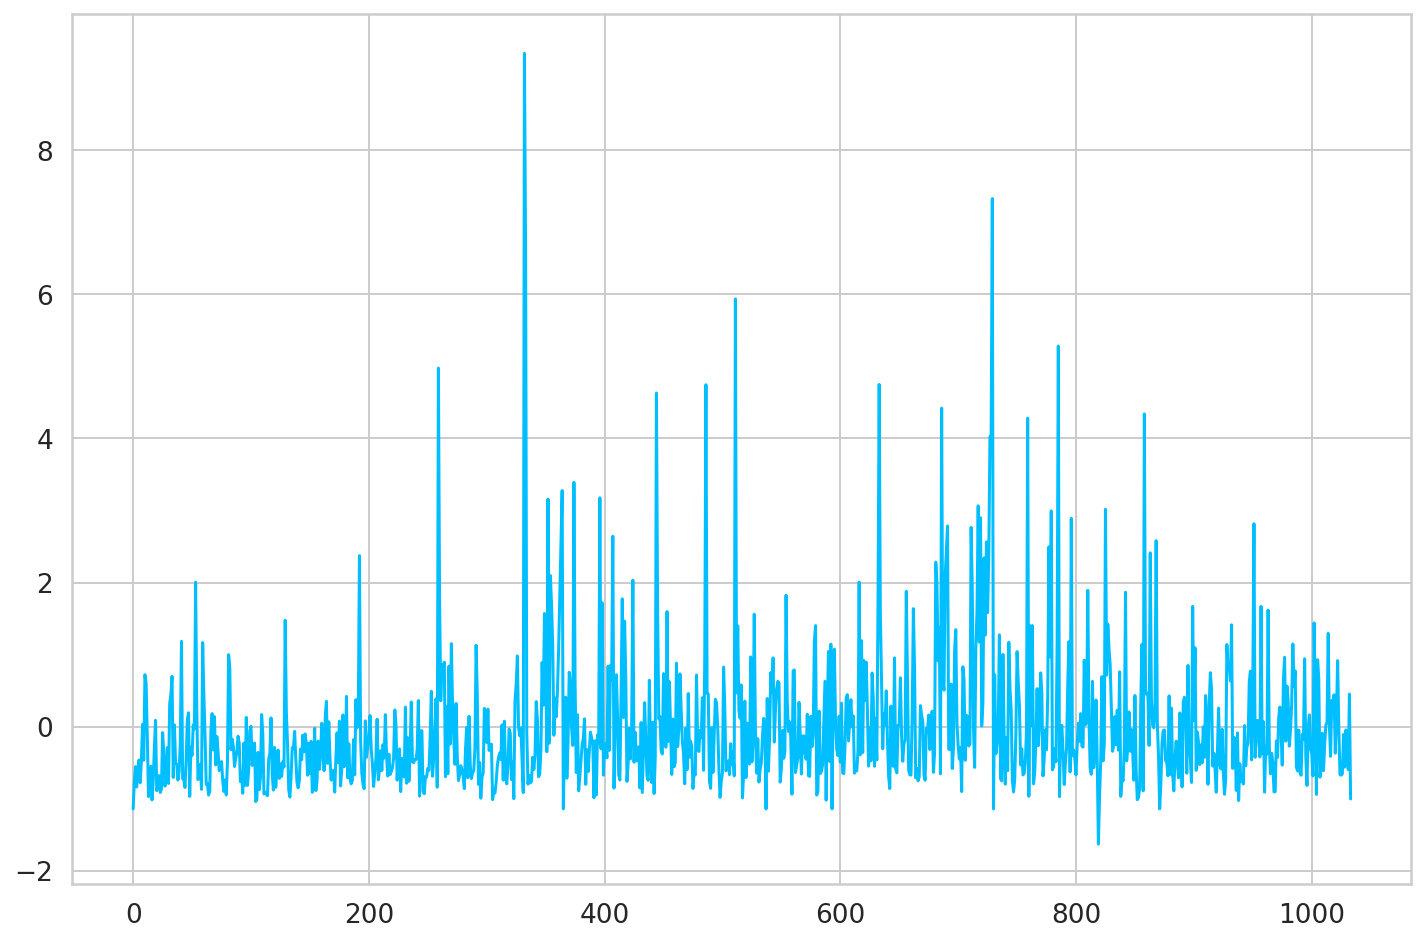

In [16]:
plt.plot(train.index,train['item_sales_total',  3])

In [17]:
train.shape

(1034, 60)

In [164]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "LSTM AE time data"

# ====== Model Capacity ====== #
args.input_size = 60
args.out_dim = 5
args.layer_node = (30,15,5)
args.actv_fn = 'relu'
args.out_actv_fn = 'relu'
args.loss_fn = 'mse'
args.early_stopping = False
args.stopping_rounds = 10
args.stopping_tolerance = 1e-5
args.method = 'basic'
args.noise_weight = 0.2
args.batch_norm = False

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True
args.vae = True

# ====== Optimizer & Training ====== #
args.optimizer = 'adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 2e-5
args.num_epochs = 50

#args.train_batch_size = 256
#args.test_batch_size = 1024

# ====== Experiment Variable ====== #
#name_var1 = 'n_layer'
#name_var2 = 'hid_dim'
#list_var1 = [1, 2, 3]
#list_var2 = [500, 300]

model_data_dir = os.path.join(os.getcwd(),'/content/drive/My Drive/LSTM_prac/sales')

In [19]:
train_df, val_df = train_test_split(
    train,
    test_size=0.2,
    random_state=seed
)

val_df, test_df = train_test_split(
    val_df,
    test_size=0.3,
    random_state=seed
)

In [20]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(827, 60)
(144, 60)
(63, 60)


In [21]:
def create_dataset(df):
    dataset = torch.tensor(df.values)
    dataset = dataset.unsqueeze(1)
    n_seq, seq_len, n_features = dataset.shape
    #n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [22]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)

In [23]:
print(train_dataset.shape)
print(val_dataset.shape)
print(test_normal_dataset.shape)

torch.Size([827, 1, 60])
torch.Size([144, 1, 60])
torch.Size([63, 1, 60])


In [24]:
train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = 1, shuffle = False)
test_loader = DataLoader(test_normal_dataset, batch_size = 1, shuffle = False)

In [49]:
next(iter(train_loader)).shape

torch.Size([1, 1, 60])

<br>

#**LSTM Auto Encoder Modeling**

In [42]:
class AutoEncoder(nn.Module):
    def __init__(self, layer_node, input_size, actv_fn, out_actv_fn, batch_norm, vae, dropout):
        super(AutoEncoder, self).__init__()
        
        self.vae = vae
        self.dropout = nn.Dropout(dropout)

        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()
        
        
        ## Activation Function 지정
        if actv_fn == 'relu':
            activation = nn.ReLU
        elif actv_fn == 'elu':
            activation = nn.ELU
        elif actv_fn == 'gelu':
            activation = nn.GELU
        elif actv_fn == 'tanh':
            activation = nn.Tanh
        elif actv_fn == 'sigmoid':
            activation = nn.Sigmoid
        else :
            print("actv_fn must be one of [relu, elu, tanh, sigmoid]")
            
        ## Activation Function 지정
        if out_actv_fn == 'relu':
            out_activation = nn.ReLU
        elif out_actv_fn == 'elu':
            out_activation = nn.ELU
        elif out_actv_fn == 'gelu':
            activation = nn.GELU
        elif out_actv_fn == 'tanh':
            out_activation = nn.Tanh
        elif out_actv_fn == 'sigmoid':
            out_activation = nn.Sigmoid
        else :
            print("out_actv_fn must be one of [relu, elu, tanh, sigmoid]")
        
        
        # Batch Normalization 지정
        if batch_norm:
            batch_norm = nn.BatchNorm1d
        else :
            batch_norm = []
            
        # nn.Sequential Layer 추가
        for i in range(len(layer_node)):
            if i == 0:
                self.encoder.add_module('h'+str(i+1), nn.LSTM(input_size, layer_node[i], batch_first = True))
                self.encoder.add_module('a'+str(i+1), activation())
#                 self.encoder.add_module('bn'+str(i+1), nn.BatchNorm2d(layer_node[i]))
            elif i != len(layer_node)-1:
                self.encoder.add_module('h'+str(i+1), nn.LSTM(layer_node[i-1], layer_node[i], batch_first = True))
                self.encoder.add_module('a'+str(i+1), activation())
            else :
                self.encoder.add_module('h'+str(i+1), nn.LSTM(layer_node[i-1], layer_node[i], batch_first = True))
        
        for j in range(len(layer_node)):
            if j != len(layer_node)-1:
                self.decoder.add_module('h'+str(j+1), nn.LSTM(layer_node[::-1][j], layer_node[::-1][j+1], batch_first = True))
                self.decoder.add_module('a'+str(j+1), activation())
            else :
                self.decoder.add_module('h'+str(j+1), nn.LSTM(layer_node[::-1][j], input_size, batch_first = True))
                self.decoder.add_module('a'+str(j+1), out_activation())

        self.output_layer = nn.Linear(input_size, input_size)     
           
        for encoder_w in self.encoder.modules():
            if isinstance(encoder_w, nn.Linear):
                nn.init.xavier_uniform_(encoder_w.weight)
        for decoder_w in self.encoder.modules():
            if isinstance(decoder_w, nn.Linear):
                nn.init.xavier_uniform_(decoder_w.weight)

    def forward(self, x):
        if self.vae:
            x = self.dropout(x)
            mu = self.encoder(x)
            logvar = self.encoder(x)
            repa_encoded_x = self.reparameterize(mu, logvar)
            decoded_x = self.decoder(repa_encoded_x)
            decoded_x = self.output_layer(decoded_x)
            return decoded_x, mu, logvar
        else :
            encoded_x = self.encoder(x)
            decoded_x = self.decoder(encoded_x)
            decoded_x = self.output_layer(decoded_x)
            return decoded_x
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        return mu + std * eps

In [76]:
class Encoder(nn.Module):

    def __init__(self, input_size, layer_node, actv_fn):
      super(Encoder, self).__init__()

      self.input_size = input_size
      self.layer_node = layer_node
          
      ## Activation Function 지정
      if actv_fn == 'relu':
          self.activation = nn.ReLU
      elif actv_fn == 'elu':
          self.activation = nn.ELU
      elif actv_fn == 'gelu':
          self.activation = nn.GELU
      elif actv_fn == 'tanh':
          self.activation = nn.Tanh
      elif actv_fn == 'sigmoid':
          self.activation = nn.Sigmoid
      else :
          print("actv_fn must be one of [relu, elu, tanh, sigmoid]")

      for i in range(len(layer_node)):
        if i == 0:
            self.rnn1 = nn.LSTM(input_size=input_size, hidden_size=layer_node[i], batch_first = True)
        elif i != len(layer_node)-1:
            self.rnn2 = nn.LSTM(input_size=layer_node[i-1], hidden_size=layer_node[i], batch_first = True)
        else:
            self.rnn3 = nn.LSTM(input_size=layer_node[i-1], hidden_size=layer_node[i], batch_first = True)

    def forward(self, x):
      x, (_, _) = self.rnn1(x)
      x, (_, _) = self.rnn2(x)
      x, (_, _) = self.rnn3(x)

      return x

In [77]:
class Decoder(nn.Module):
    def __init__(self, input_size, layer_node, actv_fn, out_actv_fn):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.layer_node = layer_node
        ## Activation Function 지정
        if actv_fn == 'relu':
            self.activation = nn.ReLU
        elif actv_fn == 'elu':
            activation = nn.ELU
        elif actv_fn == 'gelu':
            activation = nn.GELU
        elif actv_fn == 'tanh':
            activation = nn.Tanh
        elif actv_fn == 'sigmoid':
            activation = nn.Sigmoid
        else :
            print("actv_fn must be one of [relu, elu, tanh, sigmoid]")
            
        ## Activation Function 지정
        if out_actv_fn == 'relu':
            self.out_activation = nn.ReLU
        elif out_actv_fn == 'elu':
            out_activation = nn.ELU
        elif out_actv_fn == 'gelu':
            activation = nn.GELU
        elif out_actv_fn == 'tanh':
            out_activation = nn.Tanh
        elif out_actv_fn == 'sigmoid':
            out_activation = nn.Sigmoid
        else :
            print("out_actv_fn must be one of [relu, elu, tanh, sigmoid]")

        for j in range(len(layer_node)):
            if j == 0:
                self.rnn1 = nn.LSTM(input_size = layer_node[::-1][j], hidden_size = layer_node[::-1][j+1], batch_first = True)
            elif j != len(layer_node)-1:
                self.rnn2 = nn.LSTM(input_size = layer_node[::-1][j], hidden_size = layer_node[::-1][j+1], batch_first = True)
            else:
                self.rnn3 = nn.LSTM(input_size = layer_node[::-1][j], hidden_size = input_size, batch_first = True)

        self.output_layer = nn.Linear(input_size, input_size)

    def forward(self, x):

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x, (hidden_n, cell_n) = self.rnn3(x)
        x = self.output_layer(x)
        return x

In [105]:
class AutoEncoder(nn.Module):

  def __init__(self, layer_node, input_size, actv_fn, out_actv_fn, batch_norm, vae, dropout):
    super(AutoEncoder, self).__init__()

    self.vae = vae
    self.dropout = nn.Dropout(dropout)
    self.encoder = Encoder(input_size, layer_node, actv_fn).to(device)
    self.decoder = Decoder(input_size, layer_node, actv_fn, out_actv_fn).to(device)

    self.output_layer = nn.Linear(input_size, input_size)

    for encoder_w in self.encoder.modules():
      if isinstance(encoder_w, nn.Linear):
        nn.init.xavier_uniform_(encoder_w.weight)
    for decoder_w in self.encoder.modules():
      if isinstance(decoder_w, nn.Linear):
        nn.init.xavier_uniform_(decoder_w.weight)

  def forward(self, x):
    if self.vae:
            x = self.dropout(x)
            mu = self.encoder(x)
            logvar = self.encoder(x)
            repa_encoded_x = self.reparameterize(mu, logvar)
            decoded_x = self.decoder(repa_encoded_x)
            decoded_x = self.output_layer(decoded_x)
            return decoded_x, mu, logvar
    else :
            encoded_x = self.encoder(x)
            decoded_x = self.decoder(encoded_x)
            decoded_x = self.output_layer(decoded_x)
            return decoded_x

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.rand_like(std)
    return mu + std * eps

In [106]:
model = AutoEncoder(args.layer_node, args.input_size, args.actv_fn, args.out_actv_fn, args.batch_norm, args.vae, args.dropout)
model = model.cuda()
model

AutoEncoder(
  (dropout): Dropout(p=0.2, inplace=False)
  (encoder): Encoder(
    (rnn1): LSTM(60, 30, batch_first=True)
    (rnn2): LSTM(30, 15, batch_first=True)
    (rnn3): LSTM(15, 5, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(5, 15, batch_first=True)
    (rnn2): LSTM(15, 30, batch_first=True)
    (rnn3): LSTM(30, 60, batch_first=True)
    (output_layer): Linear(in_features=60, out_features=60, bias=True)
  )
  (output_layer): Linear(in_features=60, out_features=60, bias=True)
)

In [175]:
def train_model(train_loader, valid_loader, args):

    model = AutoEncoder(args.layer_node, args.input_size, args.actv_fn, args.out_actv_fn, args.batch_norm, args.vae, args.dropout)
    model = model.cuda()
    history = dict(train=[], val=[])

    ## Loss Function 지정 (MAE 존재하지 않음)
    if args.loss_fn == 'mse':
        loss_fn = nn.MSELoss(reduction='sum').cuda()
    elif args.loss_fn == 'kldiv':
        loss_fn = nn.KLDivLoss(reduction='sum').cuda()
    elif args.loss_fn == 'msekld':
        loss_fn = MSEKLDivLoss
    elif args.loss_fn == 'bcekld':
        loss_fn = BCEKLDivLoss
    else :
        loss_fn = nn.MSELoss()
        print("loss_fn must be one of [mse, kldiv, bcekld, msekld] \n selected loss_fn as mse")

    """
    ## method가 variational일 시, BCEKLDivLoss 적용하며 아닐 시, BCEKLDivLoss 적용 불가
    if args.method == 'variational' :
        if (loss_fn != BCEKLDivLoss) & (loss_fn != MSEKLDivLoss):
            loss_fn = BCEKLDivLoss
            print("When method = variational Then, loss_fn must be one of ['BCEKLDivLoss','MSEKLDivLoss']")
        else :
            loss_fn = loss_fn
    else :
        if (loss_fn == BCEKLDivLoss) or (loss_fn == MSEKLDivLoss):
            loss_fn = nn.MSELoss()
            print("When method != variational Then, loss_fn must not ['BCEKLDivLoss', 'MSEKLDivLoss']")
        else:
            loss_fn = loss_fn
    """

    ## optimizer 지정 (Adadelta 필요시 추가)
    if args.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr = args.lr)
    elif args.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr = args.lr)
    elif args.optimizer == 'rms':
        optimizer = optim.RMSprop(model.parameters(), lr = args.lr)
    else :
        print("loss_fn must be one of [adam, sgd, rms]")

    """
    ## model save directory 존재하지 않을 시, 생성 
    if os.path.isdir(model_save_dir) == False :
        os.makedirs(model_save_dir)
    """

    ## loss 평가 지표 및 bad_epoch(=stopping_epch_num) 생성
    prv_loss = np.inf
    bad_epoch = 0
    
    today_date = time.strftime('%Y%m%d', time.gmtime())
    time1 = time.time()
    
    ## method print
    if args.method in ['variational','gauss','zeros', 'basic']:
        print("Using method is", args.method)
    else : 
        args.method = 'basic'
        print("You can select method one of [variational, gauss, zeros, 'basic'] \n Using method is No noise")
    
    for i in range(args.num_epochs):
        
        ## Training epoch 진행
        model.train()
        train_losses = []
        for train_inputs in train_loader:
            
            train_dat = train_inputs.float().cuda()
            
            ## noise method 적용 (gaussian, zeros)
            if args.method == 'gauss':
                noise = torch.randn(train_dat.shape) * args.noise_weight
                train_dat = (train_dat+noise).float()
            elif args.method == 'zeros':
                noise = np.random.choice([0,1], p = (args.noise_weight, 1-args.noise_weight), size = train_dat.shape)
                train_dat = (train_dat+noise).float()
            else :
                args.method = args.method
            
            optimizer.zero_grad()
            
            if args.method == 'variational':
                train_decode, train_mu, train_logvar = model(train_dat)
                train_loss = loss_fn(train_decode[0], train_dat, train_mu, train_logvar)
                train_loss.backward()
                optimizer.step()
                
            else :
                train_decode = model(train_dat)
                train_loss = loss_fn(train_decode[0], train_dat)
                train_loss.backward()
                optimizer.step()

            train_losses.append(train_loss.item())

        ## Validation epoch 진행
        model.eval()
        val_losses = []
        for valid_inputs in valid_loader:
            
            valid_dat = valid_inputs.float().cuda()
            
            if args.method == 'variational':
                valid_decode, valid_mu, valid_logvar = model(valid_dat)
                valid_loss = loss_fn(valid_decode[0], valid_dat, valid_mu, valid_logvar)
                
            else :
                valid_decode = model(valid_dat)
                valid_loss = loss_fn(valid_decode[0], valid_dat)

            val_losses.append(valid_loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if (i % 2 == 0) or (i == args.num_epochs-1) :
            print("Now epoch : [{}/{}], train_loss:{:.4f}, valid_loss:{:.4f}".format(i + 1, args.num_epochs, train_loss.tolist(), valid_loss.tolist()))

        ## early stopping 적용 시 진행
        """    
        if args.early_stopping :
            
            if bad_epoch > args.stopping_rounds:
                print("Training Model Early Stopped in",i,"epochs.")
                print("train_loss:{:.4f}, valid_loss:{:.4f}".format(train_loss.tolist(), valid_loss.tolist()))
                break
            else :
                if prv_loss > valid_loss:
                    loss_diff = prv_loss - valid_loss
                    loss_diff = loss_diff.detach().cpu().numpy()
                    if np.round(loss_diff,5) > args.stopping_tolerance:
                        prv_loss = valid_loss
                        torch.save({'epoch': i,
                                    'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                    'train_loss': train_loss,
                                    'valid_loss': valid_loss},
                                    model_save_dir+today_date+'_'+method+'_autoencoder_model.pt')
                    else :
                        bad_epoch += 1
                        prv_loss = valid_loss
                        torch.save({'epoch': i,
                                    'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                    'train_loss': train_loss,
                                    'valid_loss': valid_loss}, 
                                    model_save_dir+today_date+'_'+method+'_autoencoder_model.pt')
                else :
                    bad_epoch += 1
                    prv_loss = prv_loss
        
        else :
            if prv_loss > valid_loss :
                prv_loss = valid_loss
                torch.save({'epoch': i,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'train_loss': train_loss,
                            'valid_loss': valid_loss},
                            model_save_dir+today_date+'_'+method+'_autoencoder_model.pt')
            else :
                prv_loss = prv_loss
        """    

    print("Training Elapsed Time : ", round((time.time() - time1)/60,3), "mins.")
    return model.eval(), history

In [176]:
model, history = train_model(train_loader, val_loader, deepcopy(args))

Using method is basic
Now epoch : [1/50], train_loss:60.9748, valid_loss:12.1998
Now epoch : [3/50], train_loss:60.8285, valid_loss:11.9754
Now epoch : [5/50], train_loss:60.7286, valid_loss:11.8091
Now epoch : [7/50], train_loss:60.6596, valid_loss:11.6840
Now epoch : [9/50], train_loss:60.6136, valid_loss:11.5951
Now epoch : [11/50], train_loss:60.5844, valid_loss:11.5326
Now epoch : [13/50], train_loss:60.5665, valid_loss:11.4937
Now epoch : [15/50], train_loss:60.5557, valid_loss:11.4599
Now epoch : [17/50], train_loss:60.5490, valid_loss:11.4457
Now epoch : [19/50], train_loss:60.5441, valid_loss:11.4301
Now epoch : [21/50], train_loss:60.5403, valid_loss:11.4204
Now epoch : [23/50], train_loss:60.5345, valid_loss:11.3881
Now epoch : [25/50], train_loss:60.5223, valid_loss:11.3551
Now epoch : [27/50], train_loss:60.4833, valid_loss:11.2125
Now epoch : [29/50], train_loss:60.3141, valid_loss:10.7206
Now epoch : [31/50], train_loss:59.1382, valid_loss:8.1763
Now epoch : [33/50], tra

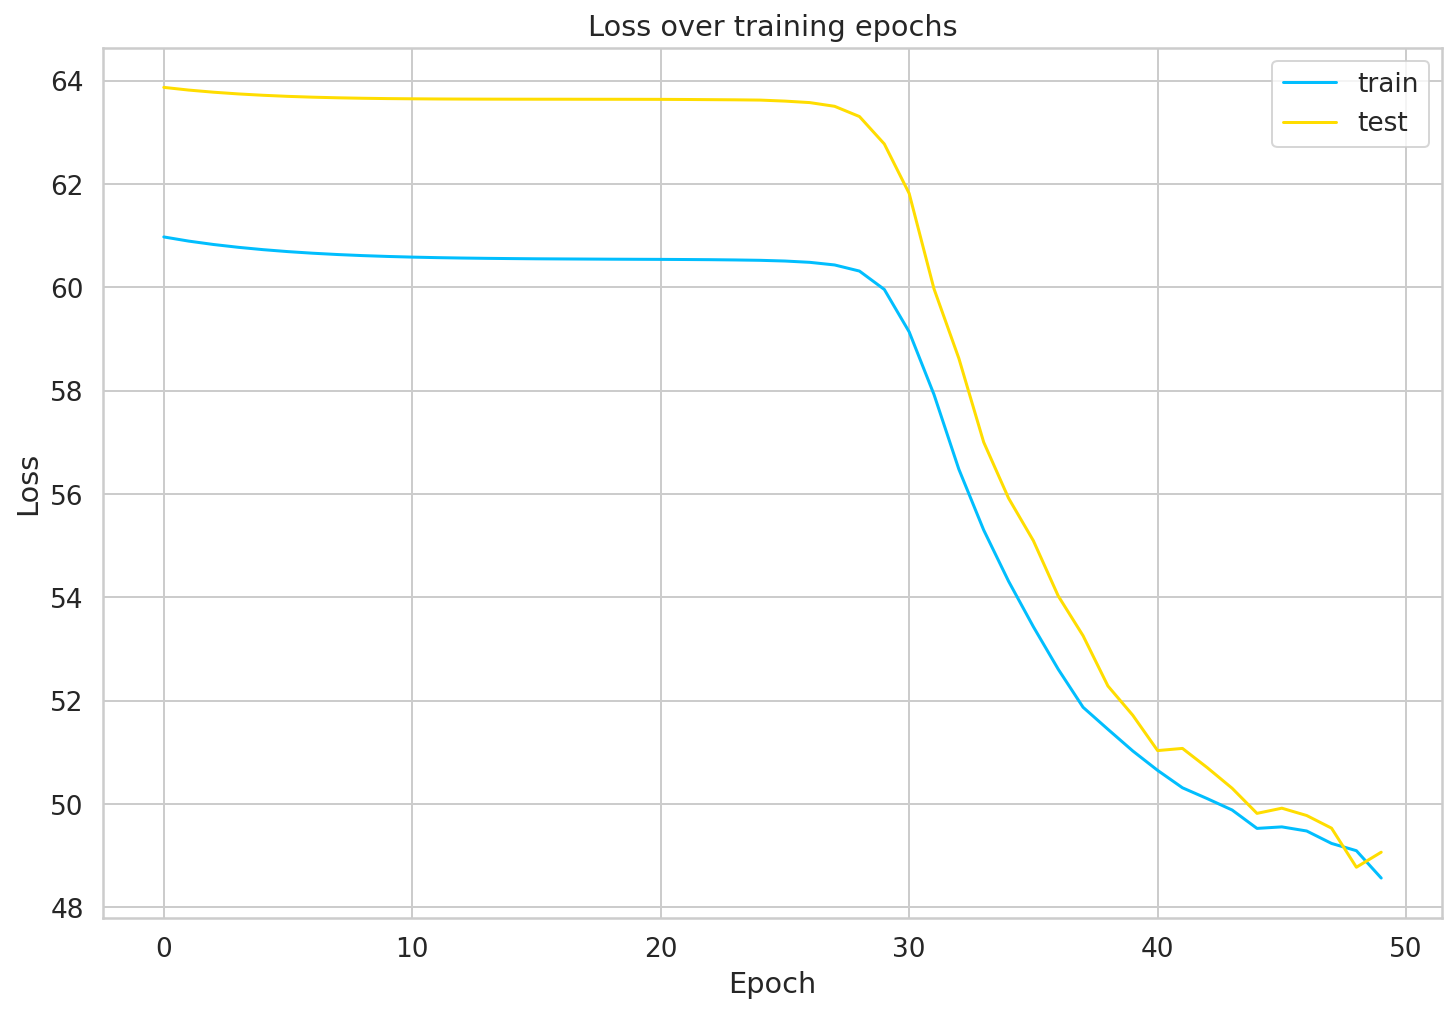

In [177]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

<br>

#**Predict Train & Test dataset**

In [189]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.float().to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred[0], seq_true)

      predictions.append(seq_pred[0].cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

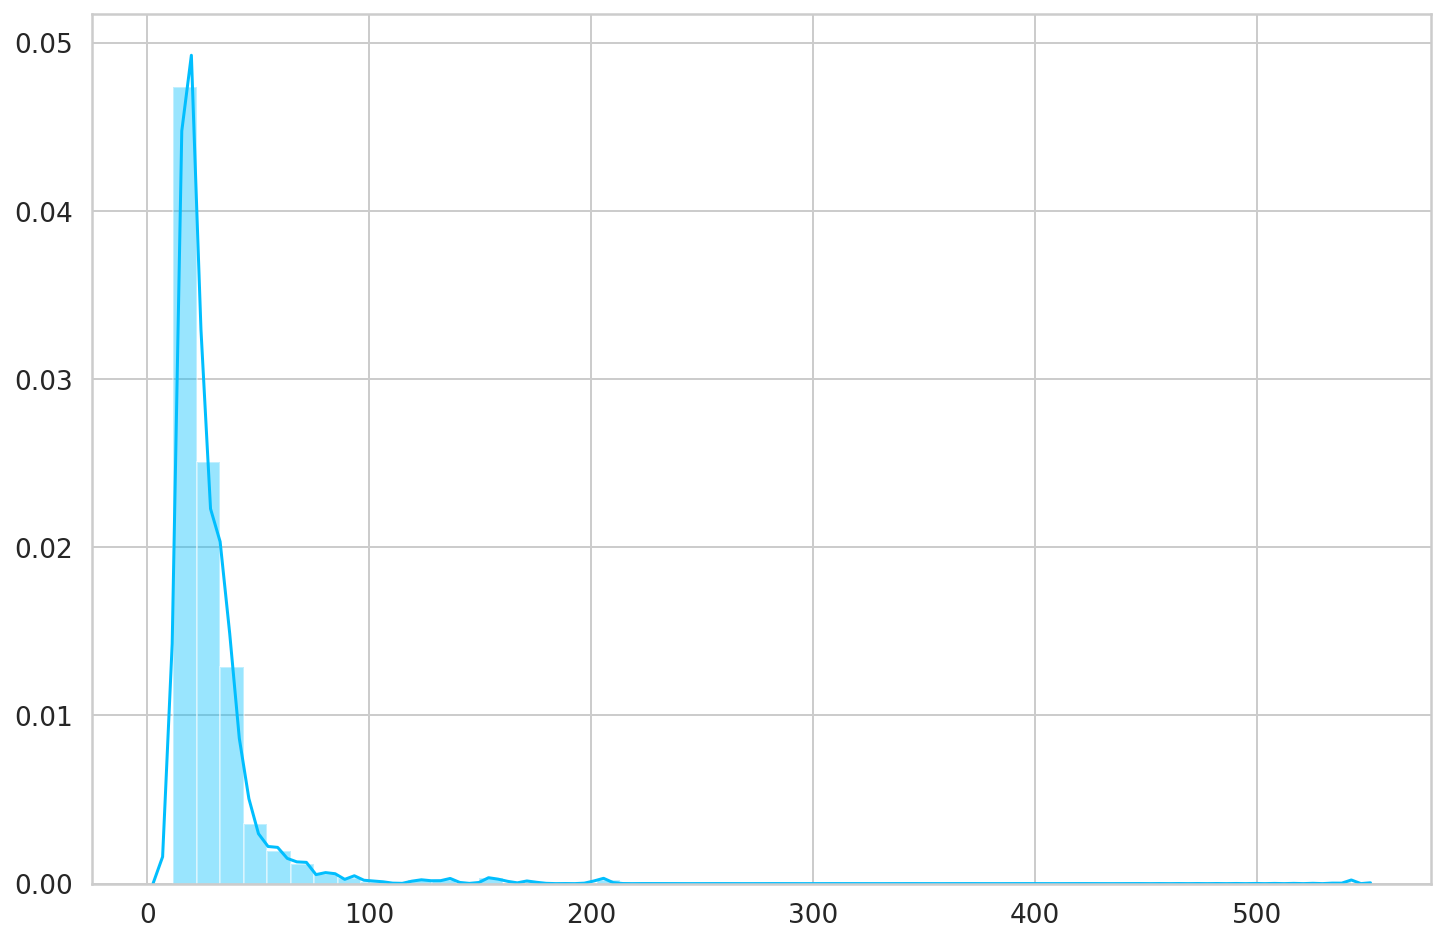

In [190]:
_, losses = predict(model, train_loader)

sns.distplot(losses, bins=50, kde=True);

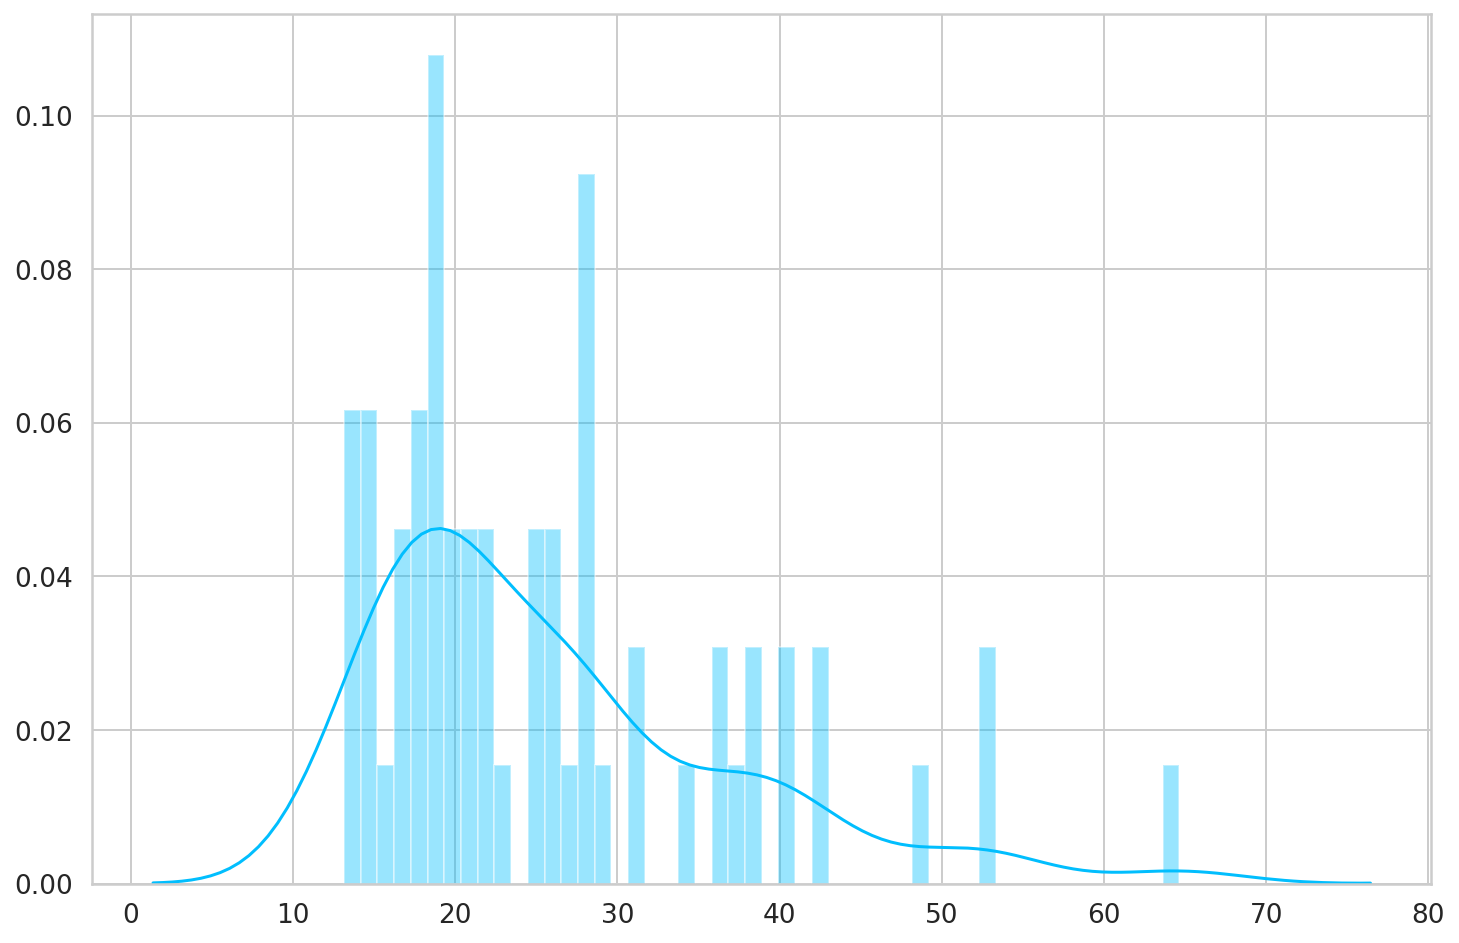

In [192]:
_, pred_losses = predict(model, test_loader)
sns.distplot(pred_losses, bins=50, kde=True);